# Astronomy Data Analysis Test & Example Script

Examples of how to use the library. 
# Table of contents
1. [Introduction](#introduction)
    1. [Why is this work relevant?](#subparagraph1)
    2. [Libraries Used](#subparagraph2)
2. [Data, Catalogs, and Background Info](#paragraph1)
3. [Scalable Algorithms](#paragraph2)
    1. [BinApprox](#subparagraph3)
4. [Cross-Matching](#paragraph3)
5. [Galaxy Classfication](#galaxy)
    1. [Features](#features)
    2. [Discussion and Challenges](#discussion)

## Introduction <a name="introduction"></a>
A small library to work with astronomy catalogs and prepare fits image files for analysis.

Sample fits files for image_stacking.py and smaller verions of both star catalogs for cross-matching can be found in the sample_data folder! Test.py and test.ipynb will default to using the sample files.

Open the test python script or ipython notebook to see examples of usage - no configuration required to run on Linux or Windows.

### Why is this work relevant? <a name="subparagraph1"></a>
For astronomy, there is an incredible amount of noise from everything you could imagine. From the limitations of our cameras to tiny flucations in the atmosphere. Our only way of interacting with our field of study is through images and simulations. Eliminating as much bias as possible and increasing the signal to noise ratio for our images is of the utmost importance. Small errors in the data can lead to centuries long condundrums as our physics based simulations consistently don't match observations. Determining whether our understanding of phyiscs is wrong or if we're getting bad data is a very hard thing. Currently, the [Hubble Constant condundrum](https://www.aps.org/publications/apsnews/201805/hubble.cfm) is a huge debate in the astronomy community - our measurements of the Hubble constant don't match. Is the way we infer distance in astronomy systematically under or over estimating distances? Do we not understand the evolution of the universe? Or are our predictions from the Standard Model flawed? Or something else?

For those reasons, it is extremely important to ensure we have the best data processing methods possible. Like the majority of data science, most of an astronomer's time is spend processing data and ensuring statistically significant results.

### Libraries Used: <a name="subparagraph2"></a>
*	astropy
*	numpy
*	scipy
*	matplotlib
*	os
*	time

For easy install of all necessary libraries:
`pip install astropy numpy scipy matplotlib`

##  Data, Catalogs, and Background Info <a name="paragraph1"></a>
Full superCOSMOS catalog data can be found [here](http://ssa.roe.ac.uk/allSky) under the Downloads heading in the first .gz file.
Full BSS catalog data can be found [here](http://cdsarc.u-strasbg.fr/viz-bin/Cat?J/MNRAS/384/775) under the FTP heading in table2.dat.

For more info on the equitorial coordinate system, see [this].(https://en.wikipedia.org/wiki/Right_ascension#/media/File:Ra_and_dec_on_celestial_sphere.png)

In [1]:
import time
import os
import scipy.spatial
import numpy as np
import sklearn
%matplotlib notebook
import matplotlib.pyplot as plt
import astronomy_data_analysis as ada

In [2]:
# Establishing working directory
parent_directory = os.getcwd()
path = os.path.join(parent_directory, 'sample_data', 'star_catalogs', '')
bss_cat = ada.cross_matching_tools.load_bss(path)
cosmos_cat = ada.cross_matching_tools.load_cosmos(path)

<IPython.core.display.Javascript object>


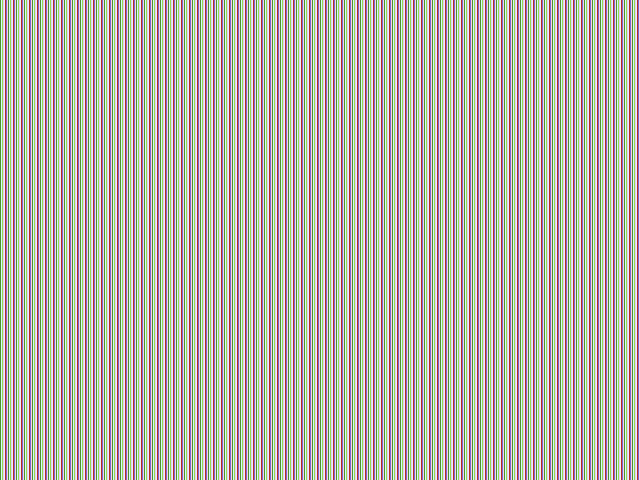

In [3]:
fig = plt.figure()
plt.title("All Data")
plt.xlabel("RA (degrees)")
plt.ylabel("DEC (degrees)")
plt.scatter(np.degrees(cosmos_cat[:, 0]), np.degrees(cosmos_cat[:, 1]), alpha=0.7, label="Comos")
plt.scatter(np.degrees(bss_cat[:,0]), np.degrees(bss_cat[:,1]), alpha=0.7, label="BSS")
plt.legend()
fig.show()

<IPython.core.display.Javascript object>


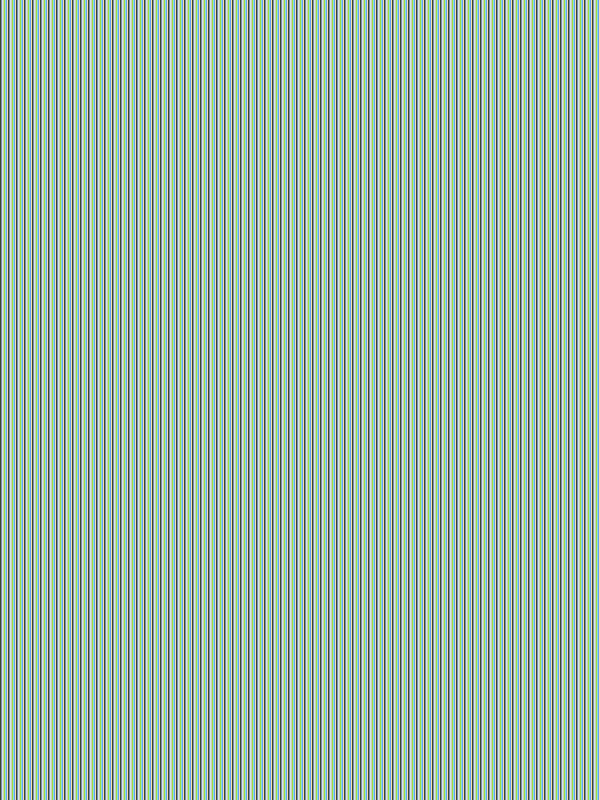

In [4]:
# Our list of fits file paths of our pulsar images
path = os.path.join(parent_directory, 'sample_data', 'pulsar_images', '')
file_list = [path + '000{0}.fits'.format(i) for i in range(0, 9)]
pulsar_list = ada.fits_tools.get_data_stack(file_list)
ada.fits_tools.plot_images(pulsar_list, title="Pulsar Images", ncols=3, subtitles=['Image {0}'.format(i) for i in range(0, 9)])

### Scalable Algorithms <a name="paragraph2"></a>
Median finding algorithms usually require loading the entire dataset into working memory. Obviously this poses problems for larger datasets. We typically want the median of a set of observations, since it is a [robust statistic](wikipedialink). We typically deal with a lot of noise and bias in astronomy, from a stray gamma ray oversaturating a pixel to poor readout to atmospheric conditions.
- implementing this numpythonically for image data.
- binapprox is a median algorithm that is detailed [here](link).
#### BinApprox  <a name="subparagraph3"></a>
This was a rather fun algorithm to implement.

In [5]:
# Demonstrating that the scalable efficient mean (scalable mean) and mean produce identical results
path = os.path.join(parent_directory, 'sample_data', 'median_images', '')
file_list = [path + 'image{0}.fits'.format(i) for i in range(0, 5)]
median_images = ada.fits_tools.get_data_stack(file_list)

In [6]:
scalable_mean, scalable_std = ada.image_stacking.scalable_stats_fits(file_list)
mean = ada.image_stacking.mean_fits(median_images)
std = ada.image_stacking.std_fits(median_images)
assert np.all(np.isclose(scalable_mean, mean))
print("Passed: Space efficient mean test")
assert np.all(np.isclose(scalable_std, std))
print("Passed: Space efficient standard deviation test")
print('===================================')

Passed: Space efficient mean test
Passed: Space efficient standard deviation test


<IPython.core.display.Javascript object>


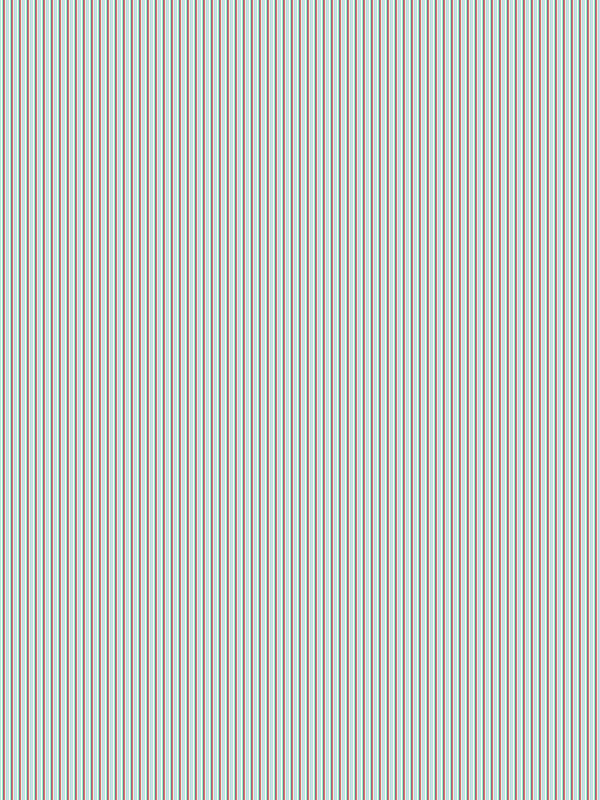

In [7]:
# Demonstrating the scalable efficient median and median
median = ada.image_stacking.median_fits(median_images)
scalable_median = ada.image_stacking.scalable_median_fits(file_list, num_bins=100)
ada.fits_tools.plot_images( np.array([median, scalable_median]),
                            title="Median Images", ncols=2,
                            subtitles=['Numpy Median', 'Binapprox Median'])

In [8]:
# Demonstrating another function from image_stacking
locations = []
for image in pulsar_list:
    brightest = ada.image_stacking.brightest_pixel(image)
    locations.append(brightest)
print("Locations of the brightest pixels: ", locations)
print('===================================')

Locations of the brightest pixels:  [(44, 187), (134, 167), (199, 166), (163, 14), (101, 135), (196, 110), (199, 125), (30, 13), (5, 190)]


## Cross-matching Examples <a name="paragraph3"></a>
One of the most universal things in astronomy research is collecting all relevant observations of the objects we want to study. These observations will come from every manner of data sources, each with their own formating and, often times, file type. Integrating these large catalogs of data into one cohesive source or, almost harder, cross-matching observations in these catalogs with their counterparts in other catalogs can be quite challenging and certainly time intensive. It's very common to have catalogs of over one million rows, so even finding the matches of a small object catalog in a larger one can take an extraordinarily long time if done naively. Here, I explore an alternative algorithm to what the best astronomy libraries use.

### Assumptions of Cross-matching: General Principle 
We want to match up observations across datasets using identifying information such as an ID, a name, or physical location. If we had two datasets sharing one ID system, this would straight forward to solve. But what about when we only have location? 

Different telescopes all over the world should, to the precision of equipment, agree that Star A is at location $(x,y)$ in [equatorial coordinates](https://en.wikipedia.org/wiki/Equatorial_coordinate_system). But since there will always be some error in that location estimate, so we can't just match coordinates exactly. So, we find the nearest neighbors (NNs) to each point in a catalog. Done naively, this takes $O(n^2)$.

### Algorithms
So, since in general we don't have estimates for where objects are *truly* in space, we visualize our data as how we see it on Earth: projected onto the surface of a sphere. Our coordinate systems in astronomy relate to, essentially, the longitude and latitude of where that object is on the Celestial Sphere. 

We measure the *angular* distance between our objects. You can see more information about the Celestial Sphere [here](https://en.wikipedia.org/wiki/Celestial_sphere).

**The Standard**  
How do we find the nearest neighbor of an object on a sphere? A hard question. Most of the preferred nearest neighbor algorithms do not respect the "wrapping" of these surfaces - 12:59 and 1:00 on a clock are very close to each other, but these algorithms would consider them to be the farthest two points on a clock. 

The most common way of dealing with this problem ([astropy](https://docs.astropy.org/en/stable/_modules/astropy/coordinates/matching.html#match_coordinates_3d), [astroML](https://github.com/astroML/astroML/blob/b4e699bf45a65e233b40d60323c05eafa1d4955e/astroML/crossmatch.py#L44)) is to embed the data into 3D space and then construct a 3D [k-d tree](https://en.wikipedia.org/wiki/K-d_tree). Then, use regular ol' $l_2$ norm (euclidean distance) to find the closest neighbor. This avoids modifying the popular nearest neighbor algorithms by relying on the fact that the [chord distance](https://i.stack.imgur.com/fRXr3.png) between two points on a sphere will be related to the true angular distance between them. 

As two points move closer together, both their angular distance and their chord distance will shrink. You can prove that the closest point on a sphere in 3D will be the point with the shortest euclidean distance as well. This euclidean distance metric will be, in general, faster to computer than the [angular distance metric](https://en.wikipedia.org/wiki/Haversine_formula), but requires converting all of your data to cartesian coordinates, with an arbitrary radius of the sphere assumed. It will always converge to the correct neighbor as well. I plan to add more visualization here showing how this 3D k-d tree approach works, but for another good resource, see [here](https://opendsa-server.cs.vt.edu/ODSA/Books/CS3/html/KDtree.html).


**Mine**  
Both these algorithms and mine rely on k-d trees to efficiently partition the space to find the nearest neighbor. For the average case, a nearest neighbor search in a k-d tree is $O(d*log(n))$, where $d$ is the dimensionality of the tree. For the examples mentioned, that would be three. For mine, two. 

My algorithm does not require embedding every data point into 3D space before using it. Hwever, it requires a much more expensive distance metric than astropy's or astroML's, which both use standard euclidean distance. This makes my algorithm better suited to cross-matching a smaller number of objects with a much larger catalog, as you can avoid the overhead of converting the large catalog to cartesian coordinates, but still have to contend with the costlier angular distance metric, which includes sines and cosines. I would like to explore exactly where this turning point in computation time lies in the future!

So my approach is to use a 2D k-d tree and allow the k-d tree to "pretend" that it does not live on a sphere. When the nearest neighbor search checks the alternative branches for other possible NN candidates, I use the true distance metric that respects the "wrapping" of our spherical data. This results in more branch switching than astropy's solution, whose effect on computational time I would like to explore. As you can see below though, it will also always converge to the correct solution.

In [9]:
# Loading the relevant catalogs
print("Starting crossmatching examples...")
path = os.path.join(parent_directory, 'sample_data', 'star_catalogs', '')
bss_cat = ada.cross_matching_tools.load_bss(path)
cosmos_cat = ada.cross_matching_tools.load_cosmos(path)

Starting crossmatching examples...


In [10]:
# First example of naive algorithm
max_dist = np.radians(5/3600)
print("This is the time taken by naive crossmatch ")
matches, no_matches = ada.naive_cross_matching.naive_crossmatch(bss_cat, cosmos_cat, max_dist)
naive_time = %timeit -n 5 -o ada.naive_cross_matching.naive_crossmatch(bss_cat, cosmos_cat, max_dist)
print("Number of matches with small search radius: ", len(matches))
print("Number of unmatched objects with small search radius: ", len(no_matches))
print('===================================')

This is the time taken by naive crossmatch 
5 loops, best of 3: 911 ms per loop
Number of matches with small search radius:  120
Number of unmatched objects with small search radius:  40


In [11]:
# Second example
max_dist = np.radians(40/3600)
matches, no_matches = ada.naive_cross_matching.naive_crossmatch(bss_cat, cosmos_cat, max_dist)
print("Number of matches with large search radius: ", len(matches))
print("Number of unmatched objects with large search radius: ", len(no_matches))
print('===================================')

Number of matches with large search radius:  151
Number of unmatched objects with large search radius:  9


As you'll see below, our k-d cross-matching algorithm is about 10 times faster than the naive algorithm for this example. That's pretty nice!

In [12]:
# First example, using k-d implementation
print("This is the time taken by k-d crossmatch ")
kd_time = %timeit -n 5 -o kd_matches, kd_no_matches = ada.kd_cross_matching.crossmatch(bss_cat, cosmos_cat, max_dist=np.radians(max_dist))
print("This is the ratio of naive crossmatch runtime to k-d runtime: ", round(naive_time.best / kd_time.best, 2))
print('===================================')

This is the time taken by k-d crossmatch 
5 loops, best of 3: 93.4 ms per loop
This is the ratio of naive crossmatch runtime to k-d runtime:  9.75


Number of naive matches with large search radius:  151
Number of naive unmatched objects with large search radius:  9


<IPython.core.display.Javascript object>


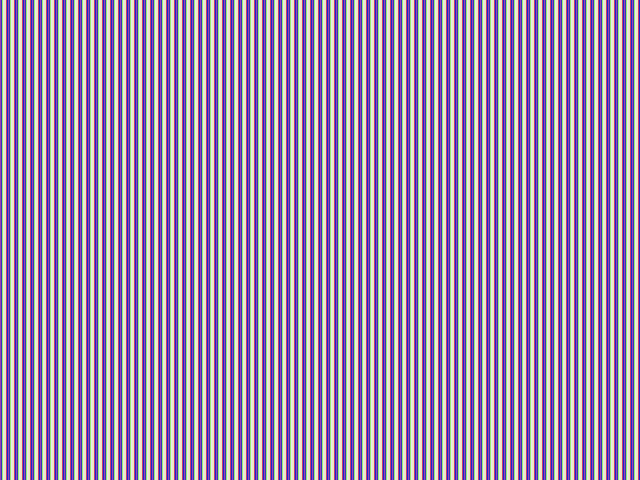

In [13]:
# 3D embedding
coor = ada.kd_cross_matching.ra_dec_to_cartesian(bss_cat)
coor2 = ada.kd_cross_matching.ra_dec_to_cartesian(cosmos_cat)

max_dist = np.radians(40/3600)
# TODO finish carrying over 3D cartesian to crossmatch
# maybe rename some of these functions
matches, no_matches = ada.kd_cross_matching.crossmatch(bss_cat, cosmos_cat, max_dist)
cat1_IDs = matches[:, 0]
cat2_IDs = matches[:, 1]
matches, no_matches = ada.naive_cross_matching.naive_crossmatch(bss_cat, cosmos_cat, max_dist)
print("Number of naive matches with large search radius: ", len(matches))
print("Number of naive unmatched objects with large search radius: ", len(no_matches))
print('===================================')
# decide for plot3D how to input points that we want to highlight
# easy for user ? - put matches in to highlight
ada.fits_tools.plot3D(np.vstack((coor, coor2)), title="3D Embedding of the Catalogs")

In [14]:
# TODO 
# compare performance of my kd tree to astropy kd tree for cross matching

## Galaxy Classification <a name="galaxy"></a>
There is a LOT of data in astronomy. And there are a LOT of galaxies. The current classification system for galaxies is inherently a little bit arbitrary, since the line between two different galaxies just beginning to collide vs a merger galaxy (the result of colliding galaxies) is a continuous one. Similar problems at the boundary lines exist for the other categories as well. Here, we explore, clean, and analyze data from Galaxy Zoo for galaxy classification.

With a random forest classifier courtesy of scipy.

## Features <a name="features"></a>
Our features are:
- color
- eccentricity (shape)
- adaptive moments (shape)
- concentrations of light (also shape information)

<IPython.core.display.Javascript object>


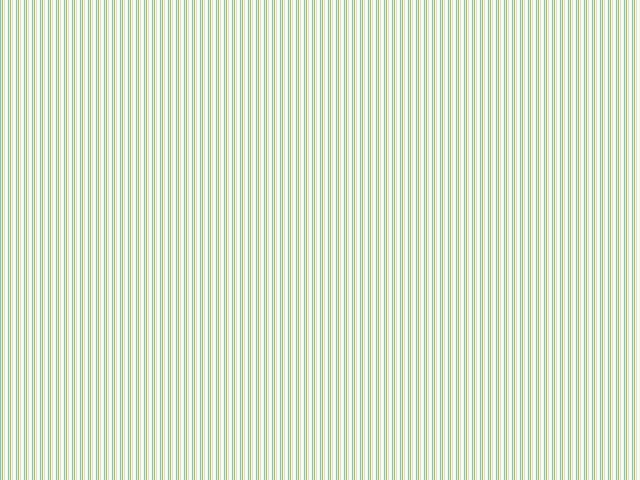

<IPython.core.display.Javascript object>


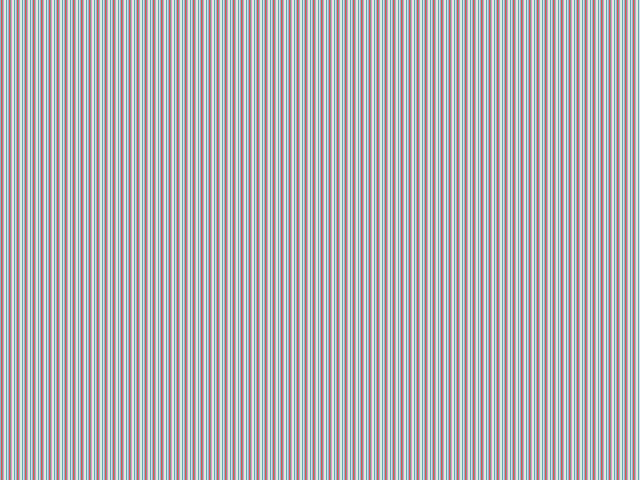

In [15]:
np.set_printoptions(suppress=True)
parent_directory = os.getcwd()
path = os.path.join(parent_directory, 'sample_data', 'galaxy_catalogs', '')
data = np.load(path+'galaxy_catalogue.npy')

# getting features and targets
features, targets = ada.galaxy_classification.generate_features_targets(data)

# getting features statistics by class and in entirety
var, mean = ada.galaxy_classification_tools.feature_stats(features, targets)
xdata = np.arange(len(var[0]))
total_var, total_mean = ada.galaxy_classification_tools.feature_stats(features)

# plotting statistics about the data set
labels = data.dtype.names[:-1]
feature_labels = list(labels[:-6]) + ["u_50_conc", "r_50_conc", "z_50_conc", "u_90_conc", "r_90_conc", "z_90_conc"]
ada.galaxy_classification_tools.plot_stats(xdata, np.vstack((var, total_var)), labels=['elliptical', 'merger', 'spiral', 'total'], xlabels=feature_labels, ylabel='std')
ada.galaxy_classification_tools.plot_stats(xdata, np.vstack((mean, total_mean)), labels=['elliptical', 'merger', 'spiral', 'total'], xlabels=feature_labels, ylabel='mean')

Accuracy score: 0.869340232858991


<IPython.core.display.Javascript object>


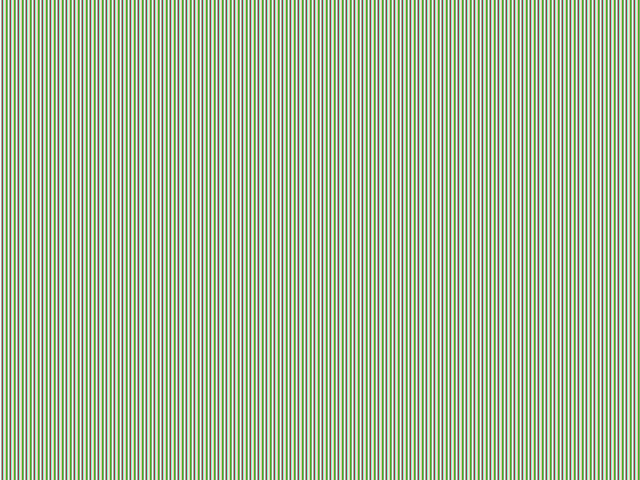

Confusion matrix, without normalization
[[208  15  34]
 [ 12 247   1]
 [ 38   1 217]]


In [16]:
# get the predicted and actual classes
number_estimators = 50              # Number of trees
predicted, actual = ada.galaxy_classification.predict(data, number_estimators)

# calculate the model score
accuracy = ada.galaxy_classification_tools.calculate_accuracy(predicted, actual)
print("Accuracy score:", accuracy)

# calculate the models confusion matrix using sklearns confusion_matrix function
class_labels = list(set(actual))
model_cm = sklearn.metrics.confusion_matrix(y_true=actual, y_pred=predicted, labels=class_labels)

# plot the confusion matrix
ada.galaxy_classification_tools.plot_confusion_matrix(model_cm, classes=class_labels, normalize=False)

## Discussion and Challenges <a name="discussion"></a>
By and large, our model struggled with the merger class the most.

The dataset was visually classified by humans on GalaxyZoo, so the features trained on are not the features used for classification. Only elliptical and spiral galaxies that were classified with 100% agreement amount GalaxyZoo users were included in the dataset. Since mergers make up a much smaller fraction of galaxies in general, that threshold was dropped to 80% agreement.

This begs the question - can we expect our model to outperform humans? On average, our model correctly labels ~80% of all mergers. If up to 20% of humans would classify our merger data as another galaxy, does it make sense to ask much more of our model? 

So we see there is some inherent ambiguity in our classes.